<a href="https://colab.research.google.com/github/JAEHYEONG8121/Pytorch-Tutorial/blob/main/02_WGAN_with_gradient_penalty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## WGAN

- PROS
  - Better stability
  - Loss means something: Termination criteria

- CON
  - Longer to train?

***

> To understand WGAN, lets recap GANs



**1. Probability distribution in the Discriminator**
- The discriminator's job is to distinguish between real and fake data.
- It learns the probability distribution of real data and compares it to the distribution of fake data generated by the Generator.
- It learns to distinguish between two distributions:
  - Pdata(x) : The true data distribution
  - Pg(x) : The distribution of fake data generated by the Generator


**2. Probabilty distribution in the Generator**
- The generator's role is to create fake data that looks similar to real data.
- It takes a random noise vector z as input and generates fake data.
- The goal is to adjust Pg(x) such that it becomes as close as possible to the true data distribution Pdata(x).

**3. How the probability distributions evolve during GAN traning**
- During traning, the GAN's objective is to align the fake data distribution Pg(x) with the real data distribution Pdata(x).
- The ultimate goal is for Pg(x) to converge towards Pdata(x), at which point the discriminator cannot tell the difference between real and fake data, and outputs approximately 0.5 for both.

**4. Measuring distance between probability distributions**
- The loss function in GANs measures the difference between the real and fake data distributions.
- In the original GAN, JS Divergence is used to mesure this distance.

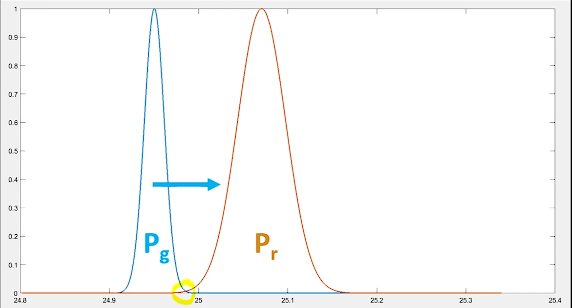



***

**WGAN**

- GAN Loss used so far is equivalent to JS divergence.
- But, JS divergence has gradients issues leading to unstable learning
- WGAN instead bases its loss from 'Wasserstein Distance'

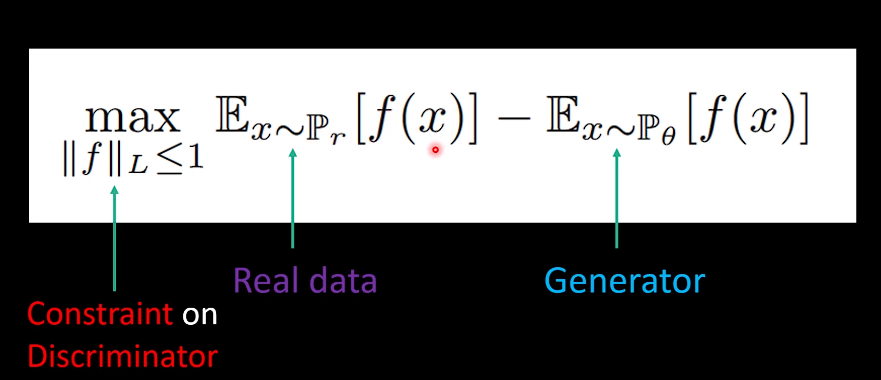




In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import CelebA

In [2]:
LOG_DIR = "runs2"
writer_fake = SummaryWriter(f"{LOG_DIR}/fake")
writer_real = SummaryWriter(f"{LOG_DIR}/real")

In [3]:
# TensorBoard를 Colab에서 사용하기 위한 확장 기능 불러오기
%load_ext tensorboard

In [4]:
class Discriminator(nn.Module):
  def __init__(self, channels_img, features_d):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        # Input: N x channels_img x 64 x 64
        nn.Conv2d(
            channels_img, features_d, kernel_size=4, stride=2, padding=1
        ), # 32 x 32
        nn.LeakyReLU(0.2),
        self._block(features_d, features_d*2, 4, 2, 1,), # 16x16
        self._block(features_d*2, features_d*4, 4, 2, 1),# 8x8
        self._block(features_d*4, features_d*8, 4, 2, 1),# 4x4
        nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0), # 1x1
    )

  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False,
        ),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2),
    )

  def forward(self, x):
    return self.disc(x)

In [5]:
class Generator(nn.Module):
  def __init__(self, z_dim, channels_img, features_g):
    super(Generator, self).__init__()
    self.gen = nn.Sequential(
        # Input: N x z_dim x 1 x 1
        self._block(z_dim, features_g*16, 4, 1, 0), # N x f_g*16 x 4 x 4
        self._block(features_g*16, features_g*8, 4, 2, 1), # 8x8
        self._block(features_g*8, features_g*4, 4, 2, 1), # 16x16
        self._block(features_g*4, features_g*2, 4, 2, 1), # 32x32
        nn.ConvTranspose2d(
            features_g*2, channels_img, kernel_size=4, stride=2, padding=1,
        ),
        nn.Tanh(), # [-1, 1]
    )

  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False,
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

  def forward(self, x):
    return self.gen(x)

In [6]:
# Hyperparameters etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 5e-5
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.01

In [7]:
def initialize_weights(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.02)

def test():
  N, in_channels, H, W = 8, 3, 64, 64
  z_dim = 100
  x = torch.randn((N, in_channels, H, W))
  disc = Discriminator(in_channels, 8)
  initialize_weights(disc)
  assert disc(x).shape == (N, 1, 1, 1)
  gen = Generator(z_dim, in_channels, 8)
  initialize_weights(gen)
  z = torch.randn((N, z_dim, 1, 1))
  assert gen(z).shape == (N, in_channels, H, W)
  print("Success")

#test()

In [1]:
transforms = T.Compose(
    [
        T.Resize(IMAGE_SIZE),
        T.ToTensor(),
        T.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]),
    ]
)

dataset = torchvision.datasets.CelebA(root='celeb_dataset', download=True, transform=transforms)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(critic)

NameError: name 'T' is not defined

In [ ]:
opt_gen = optim.RMSprop(gen.parameters(), lr=LEARNING_RATE)
opt_critic = optim.RMSprop(critic.parameters(), lr=LEARNING_RATE)

In [ ]:
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

step = 0

gen.train()
critic.train()

for epoch in range(NUM_EPOCHS):
  for batch_idx, (real, _) in enumerate(loader):
    real = real.to(device)
    noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
    fake = gen(noise)

    for _ in range(CRITIC_ITERATIONS):
      noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
      fake = gen(noise)
      critic_real = critic(real).reshape(-1)
      critic_fake = critic(fake).reshape(-1)
      loss_critic = - (torch.mean(critic_real) - torch.mean(critic_fake))
      critic.zero_grad()
      loss_critic.backward(retain_graph=True)
      opt_critic.step()

      for p in critic.parameters():
        p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

    ### Train Generator: min -E[critic(gen_fake)]
    output = critic(fake).reshape(-1)
    loss_gen = -torch.mean(output)
    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()



    # Print losses occasinally and print to tensorboard
    if batch_idx % 100 == 0:
      print(
          f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                    Loss D: {loss_critic: .4f}, Loss G: {loss_gen: .4f}"
      )

      with torch.no_grad():
        fake = gen(fixed_noise)

        # take out (up to) 32 examples
        img_grid_real = torchvision.utils.make_grid(
            real[:32], normalize=True
        )
        img_grid_fake = torchvision.utils.make_grid(
            fake[:32], normalize=True
        )

        writer_real.add_image("Real", img_grid_real, global_step=step)
        writer_fake.add_image("Fake", img_grid_fake, global_step=step)

      step += 1